In [44]:
"""
%pip install qiskit==2.1.2
%pip install qiskit-ibm-runtime==0.41.1
%pip install qiskit-aer==0.17.2
%pip install pylatexenc
"""

'\n%pip install qiskit==2.1.2\n%pip install qiskit-ibm-runtime==0.41.1\n%pip install qiskit-aer==0.17.2\n%pip install pylatexenc\n'

In [45]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

# Overview

This is the first example in the Quantum Error Correction (QEC) Code series. The main objective of this series of codes is to introduce the reader to the world of quantum error correction through small examples of codes, stabilizers, noise models, and practical experiments. In this first Jupyter notebook, we will introduce the [[2,1,2]] code. The [[2,1,2]] detection code is a very simple example to start with; it has only two physical qubits, protects only one physical qubit by creating a logical one, and, due to its distance $d=2$, it will not be possible to apply error correction, since if 1 error occurs, we will not know exactly where the error happened.To conduct our experiments and attest to the effectiveness of error detection/correction, we will almost always follow the same procedure:

1. We will create a noisy model of how the quantum circuit should behave, including which gates are noisy and on which qubits these errors are allowed. We will always leave the ancillas, which are responsible for storing the error detection, error-free to avoid false positives.

2. Sometimes, whenever possible, we will compare a noisy result with a noise-free one, or a circuit without error correction with one that has error correction.

# 1°: Create the Noisy Model

In the code cell below, we create the noisy circuit model with adjustable error probability using Qiskit Aer. We also select the noisy quantum gates and specify on which qubits the error model should be applied.

In [46]:
noise_model = NoiseModel()
p_error_1q = 0.1
noisy_gates = ['id','rx', 'ry', 'rz', 'sx', 'x', 'h']
error_1q = depolarizing_error(p_error_1q, 1)
noise_model.add_quantum_error(error_1q,  noisy_gates, [0])
noise_model.add_quantum_error(error_1q, noisy_gates, [1])

# 2°: Create the Circuit Without Error Introduction


In the code cells, we create a noise-free circuit, or one that will be executed on a noise-free simulator. The idea is for it to serve as a comparison and to see how an ideal circuit on an ideal device should behave. In this circuit, all results obtained from the simulation must belong to the codespace, and all ancillas with the syndrome must be in the 0 state, indicating that no error was detected during the computation process.

In [47]:
q_data = QuantumRegister(2, name='q')
q_syn = QuantumRegister(1, name='syn')
c_data = ClassicalRegister(2, name='c_data')
c_syn = ClassicalRegister(1, name='c_syn')

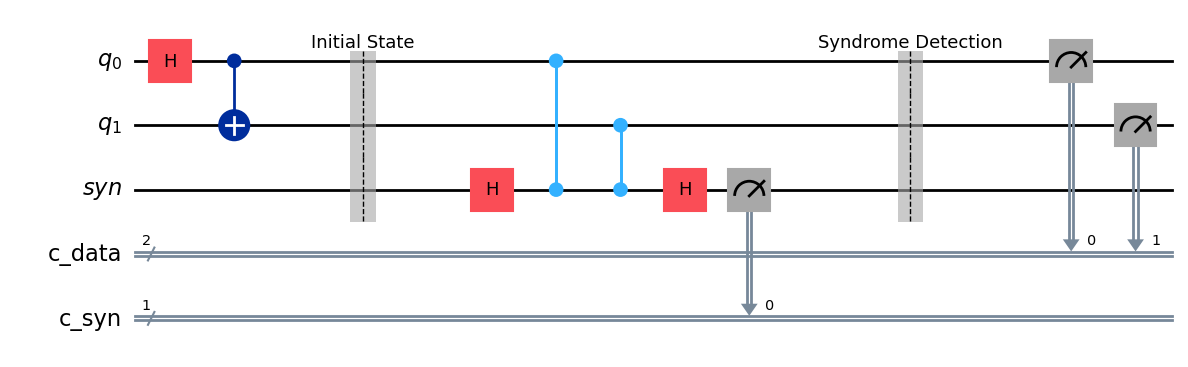

In [48]:
noiseless_circ = QuantumCircuit(q_data, q_syn, c_data, c_syn)

noiseless_circ.h(0)
noiseless_circ.cx(q_data[0], q_data[1])
noiseless_circ.barrier(label="Initial State")

noiseless_circ.h(q_syn[0])
noiseless_circ.cz(q_syn[0], q_data[0])
noiseless_circ.cz(q_syn[0], q_data[1])
noiseless_circ.h(q_syn[0])
noiseless_circ.measure(q_syn[0], c_syn[0])
noiseless_circ.barrier(label="Syndrome Detection")

noiseless_circ.measure(q_data[0], c_data[0])
noiseless_circ.measure(q_data[1], c_data[1])

noiseless_circ.draw('mpl')

# 3°: Create the Circuit With Error Introduction


In this cell, we will create a noisy circuit model. We will create the error detection circuit, but we will add a step with a double application of the Pauli X gate. This is intentional; given the chance of an error occurring (adjustable in the first code cell), we will apply the gate and then undo it, which has no mathematical effect on the quantum state since the gates are unitary and Hermitian. However, this should have an effect on the noisy circuit. We expect to obtain (smaller) results of states outside the codespace, with the ancillas flagging an error (different from 0).

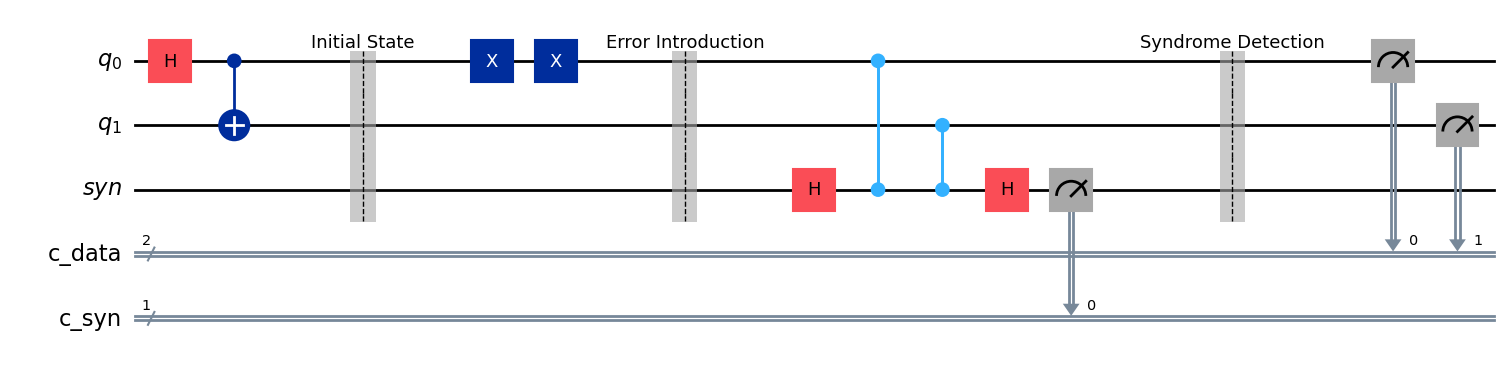

In [49]:
noisy_circ = QuantumCircuit(q_data, q_syn, c_data, c_syn)
noisy_circ.h(0)
noisy_circ.cx(q_data[0], q_data[1])
noisy_circ.barrier(label="Initial State")

noisy_circ.x(q_data[0])
noisy_circ.x(q_data[0])

noisy_circ.barrier(label="Error Introduction")

noisy_circ.h(q_syn[0])
noisy_circ.cz(q_syn[0], q_data[0])
noisy_circ.cz(q_syn[0], q_data[1])
noisy_circ.h(q_syn[0])
noisy_circ.measure(q_syn[0], c_syn[0])
noisy_circ.barrier(label="Syndrome Detection")

noisy_circ.measure(q_data[0], c_data[0])
noisy_circ.measure(q_data[1], c_data[1])
noisy_circ.draw('mpl')

# 4°: Results View


As we expected, the simulation results can be viewed in the code cells below. In the noise-free simulation, all results belong to the codespace, with the ancilla qubit having the value 0 (the leftmost qubit). However, the noisy simulations generated results both inside the codespace and outside the codespace, with the ancilla qubit flagging a value different from 0 for results outside the codespace (as we desired). The experiment's result is in accordance with the theory. As stated at the beginning, it will not be possible to apply an error correction code because the code distance is $d=2$. However, the [[3,1,3]] code will allow us to apply not only error detection but also error correction.

In [50]:
sim_noiseless = AerSimulator()
sim_noise = AerSimulator(noise_model=noise_model)

shots = 1024
noiseless_job = sim_noiseless.run(noiseless_circ, shots=shots)
noisy_job = sim_noise.run(noisy_circ, shots=shots)

noiseless_count = noiseless_job.result().get_counts()
noisy_count = noisy_job.result().get_counts()


print(f"Noiseless Simulation: {noiseless_count}")
print(f"Noisy Simulation: {noisy_count}")


Noiseless Simulation: {'0 00': 487, '0 11': 537}
Noisy Simulation: {'1 10': 51, '1 01': 45, '0 11': 463, '0 00': 465}


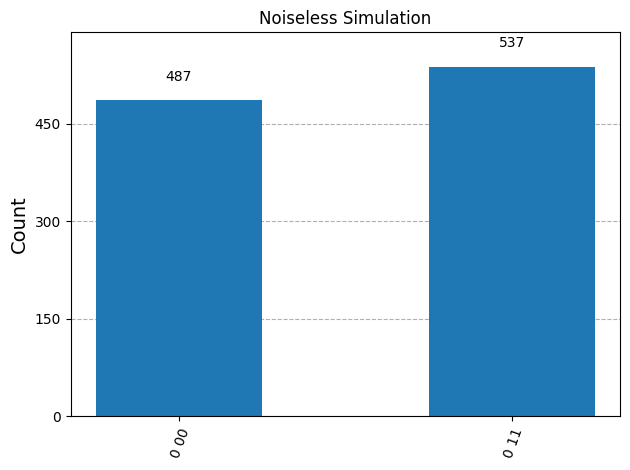

In [52]:
plot_histogram(title='Noiseless Simulation',data=noiseless_count)

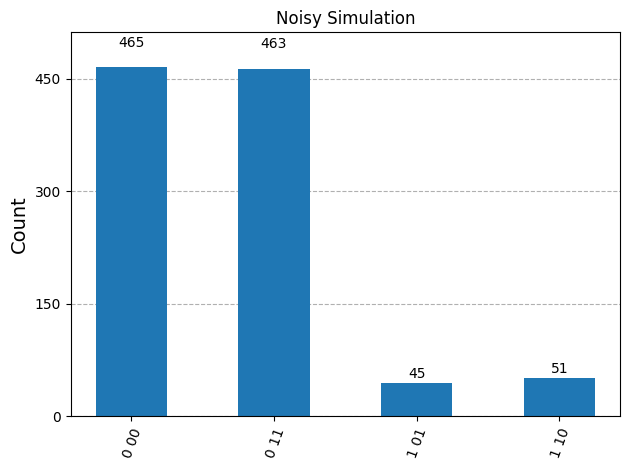

In [51]:
plot_histogram(title='Noisy Simulation',data=noisy_count)